In [1]:
from utils import write_loss, get_config, Timer
from trainer import MUNIT_Trainer, UNIT_Trainer
import torch.backends.cudnn as cudnn
import torch

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import json
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from fid_score import calculate_frechet_distance

from my_utils import (multiple_gpu_gen, multiple_gpu_dis,
                      load_dataset, LoaderSampler, tensor2img,
                      get_Z_pushed_loader_stats)

from IPython.display import clear_output

cudnn.benchmark = True

# Load experiment setting
opts_trainer = "MUNIT"
opts_output_path = "."
opts_resume = False
opts_config = "configs/handbags2shoes.yaml"


config = get_config(opts_config)
max_iter = config['max_iter']
display_size = config['display_size']
config['vgg_model_path'] = opts_output_path
batch_size = config['batch_size']

DEVICE_IDS = [3, 4]
SEED = 0x000000

device = f'cuda:{DEVICE_IDS[0]}'

# Setup model and data loader
if opts_trainer == 'MUNIT':
    trainer = MUNIT_Trainer(config, device).to(device)
elif opts_trainer == 'UNIT':
    trainer = UNIT_Trainer(config).to(device)
else:
    sys.exit("Only support MUNIT|UNIT")

trainer.gen_a = multiple_gpu_gen(trainer.gen_a, DEVICE_IDS)
trainer.gen_b = multiple_gpu_gen(trainer.gen_b, DEVICE_IDS)

trainer.dis_a = multiple_gpu_dis(trainer.dis_a, DEVICE_IDS)
trainer.dis_b = multiple_gpu_dis(trainer.dis_b, DEVICE_IDS)

DATASET1, DATASET1_PATH = 'handbag', '../data/handbag_128.hdf5'
DATASET2, DATASET2_PATH = 'shoes', '../data/shoes_128.hdf5'

IMG_SIZE = 64

filename = 'stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

torch.cuda.set_device(device)
torch.manual_seed(SEED)
np.random.seed(SEED)

train_loader_a, test_loader_a = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=batch_size)
train_loader_b, test_loader_b = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=batch_size)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

X_fixed_arr = []
Y_fixed_arr = []
X_test_fixed_arr = []
Y_test_fixed_arr = []
for i in range(10):
    X_fixed_arr.append(X_sampler.sample(1))
    Y_fixed_arr.append(Y_sampler.sample(1))
    X_test_fixed_arr.append(X_test_sampler.sample(1))
    Y_test_fixed_arr.append(Y_test_sampler.sample(1))

X_fixed = torch.cat(X_fixed_arr)
Y_fixed = torch.cat(Y_fixed_arr)
X_test_fixed = torch.cat(X_test_fixed_arr)
Y_test_fixed = torch.cat(Y_test_fixed_arr)

print(f"X_fixed shape = {X_fixed.shape}")
print(f"Y_fixed shape = {Y_fixed.shape}")
# Setup logger and output folders
model_name = os.path.splitext(os.path.basename(opts_config))[0]

OUTPUT_PATH = '../checkpoints/MUNIT/{}_{}_{}'.format(DATASET1, DATASET2, IMG_SIZE)
writer = SummaryWriter(os.path.join(OUTPUT_PATH, "tensorboard"))
path_to_save_fig = os.path.join(OUTPUT_PATH, "figs")
if not os.path.exists(path_to_save_fig):
    os.makedirs(path_to_save_fig)

path_to_save_models = os.path.join(OUTPUT_PATH, "models")
if not os.path.exists(path_to_save_models):
    os.makedirs(path_to_save_models)

Keys: KeysView(<HDF5 file "handbag_128.hdf5" (mode r)>)


/home/work/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Keys: KeysView(<HDF5 file "shoes_128.hdf5" (mode r)>)
X_fixed shape = torch.Size([10, 3, 64, 64])
Y_fixed shape = torch.Size([10, 3, 64, 64])


Plotting, step = 10001
Step 10001, gen_a2b, train


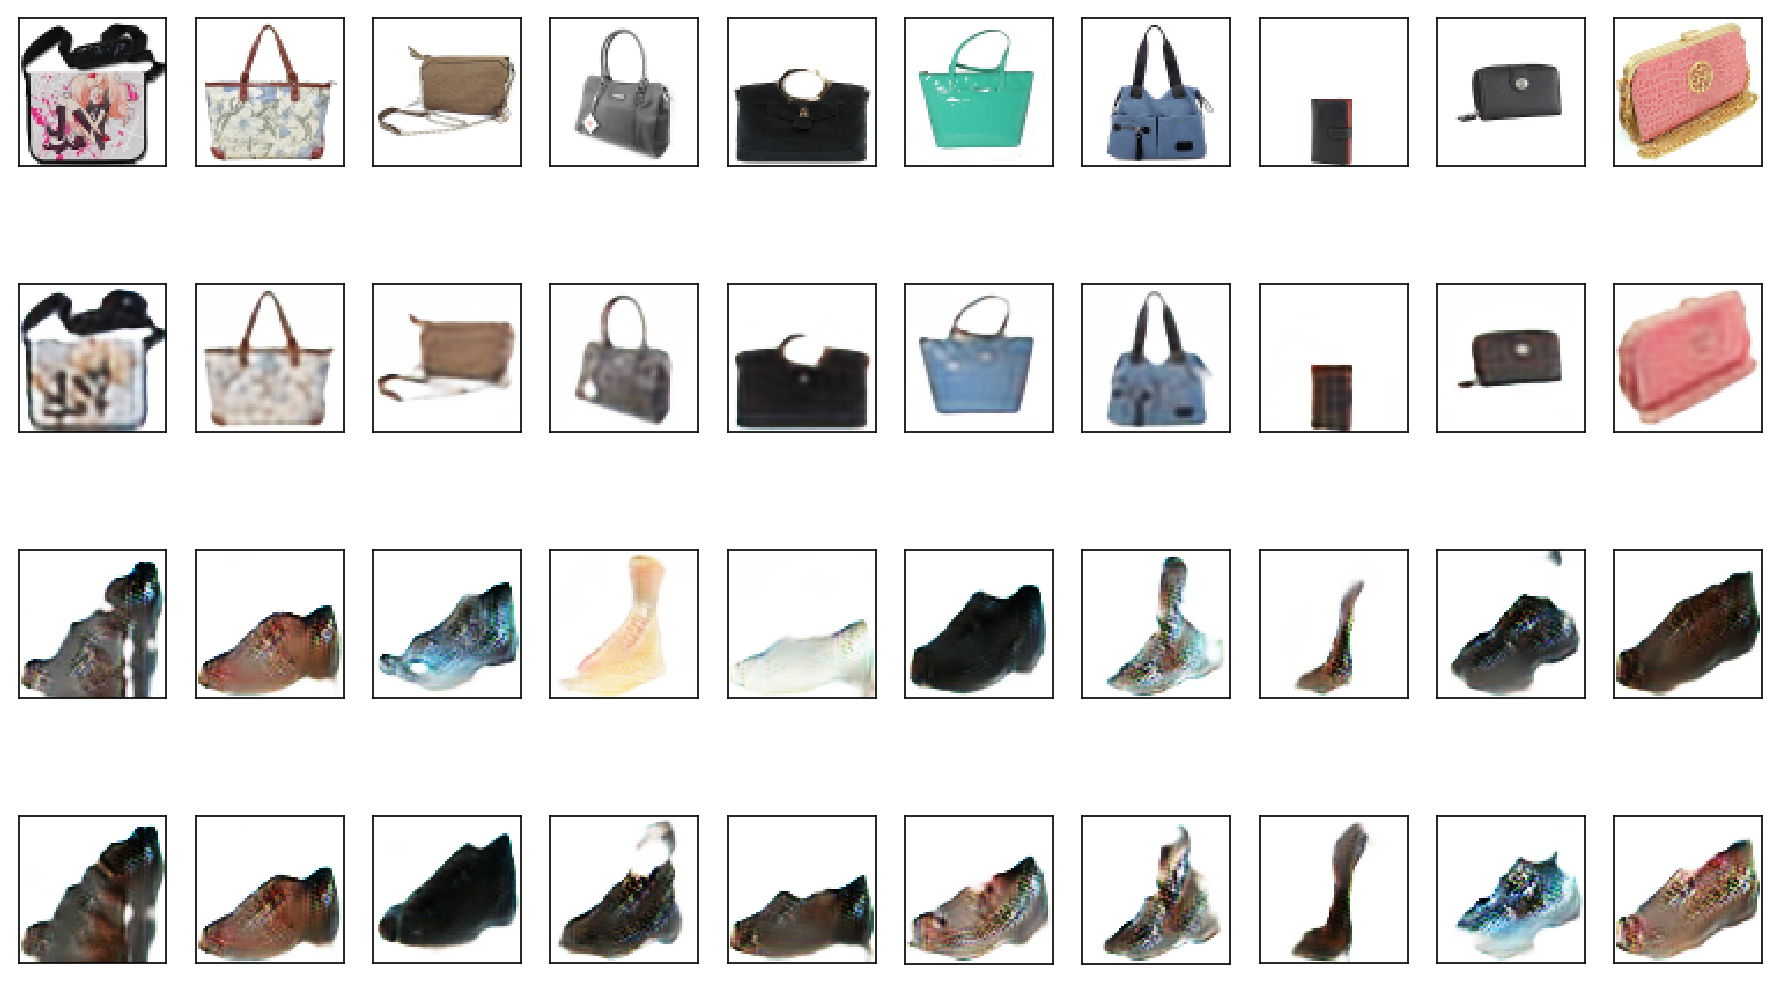

Step 10001, gen_a2b, test


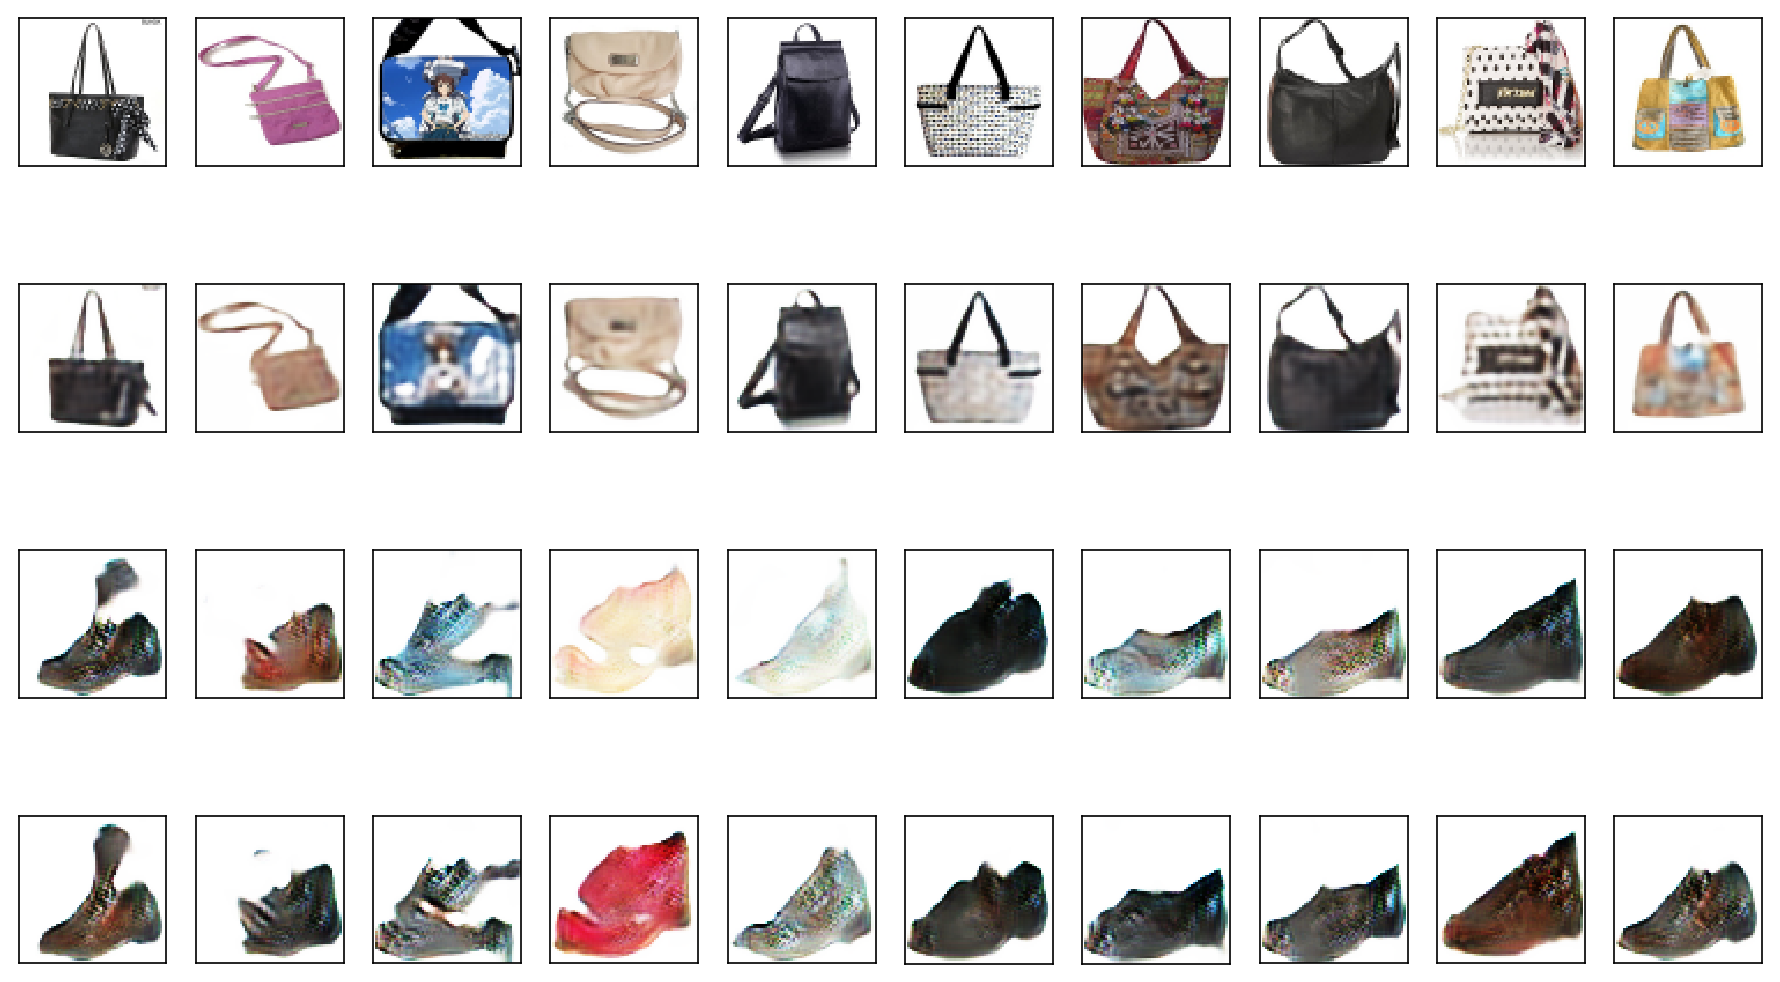

Step 10001, gen_b2a, train


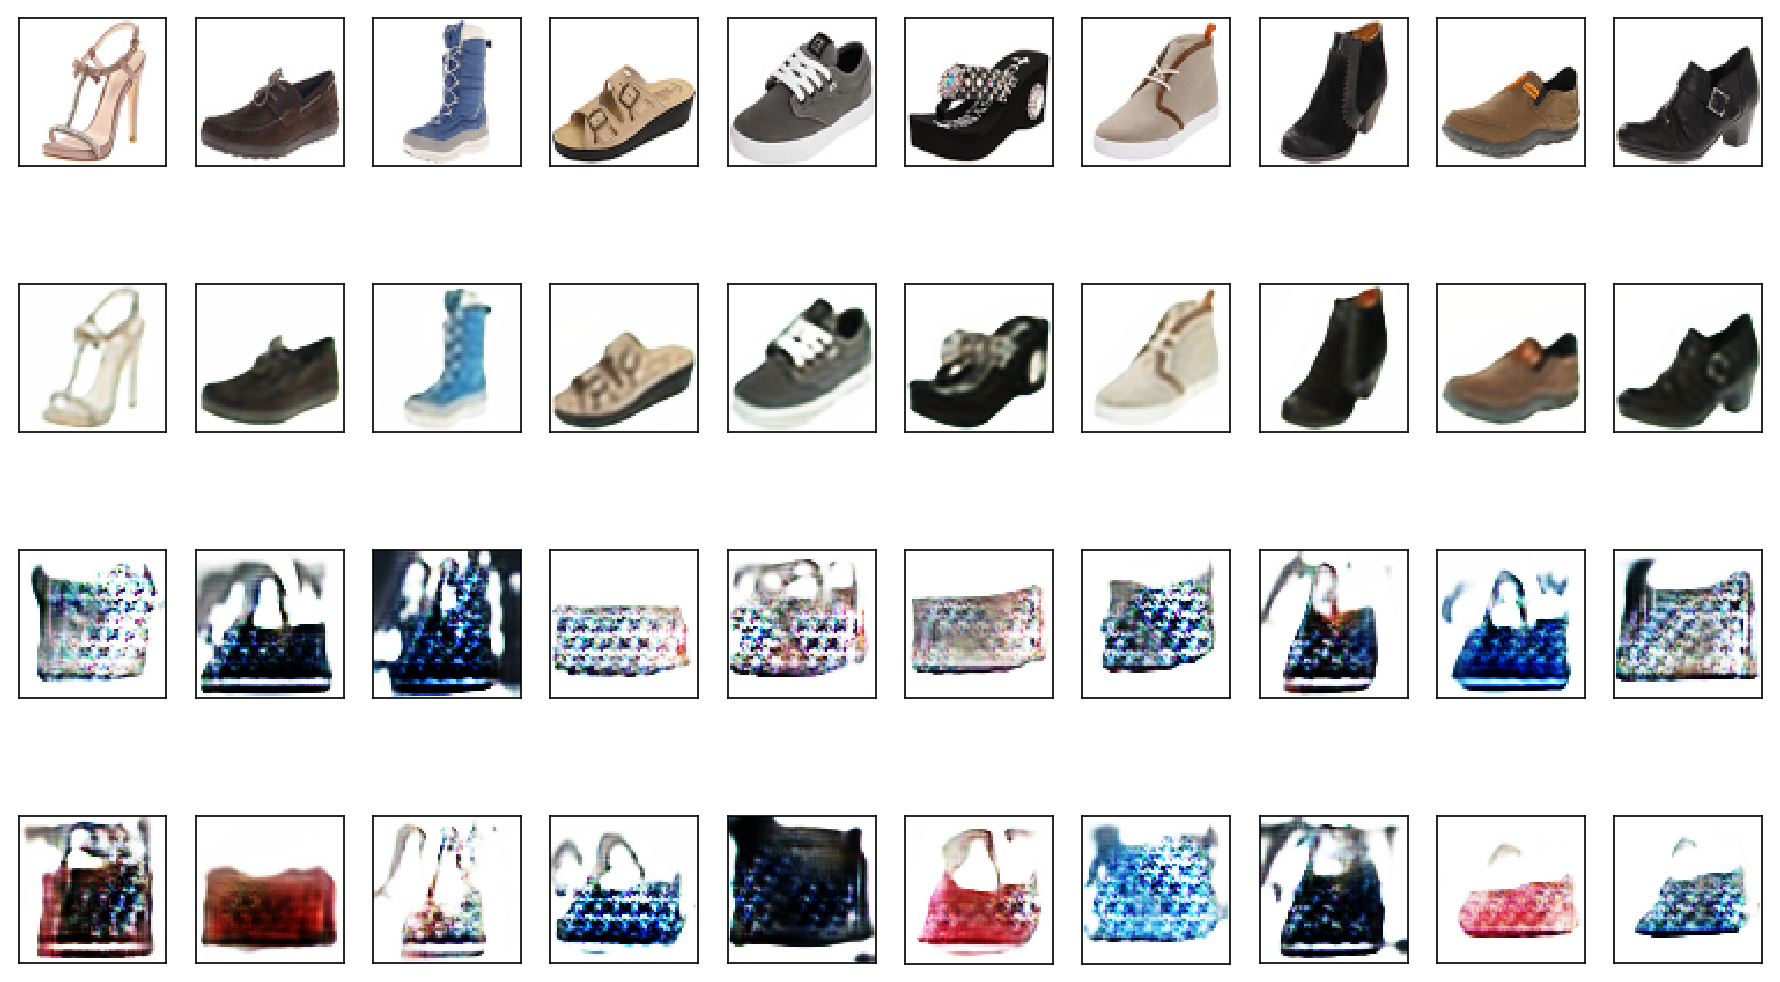

Step 10001, gen_b2a, test


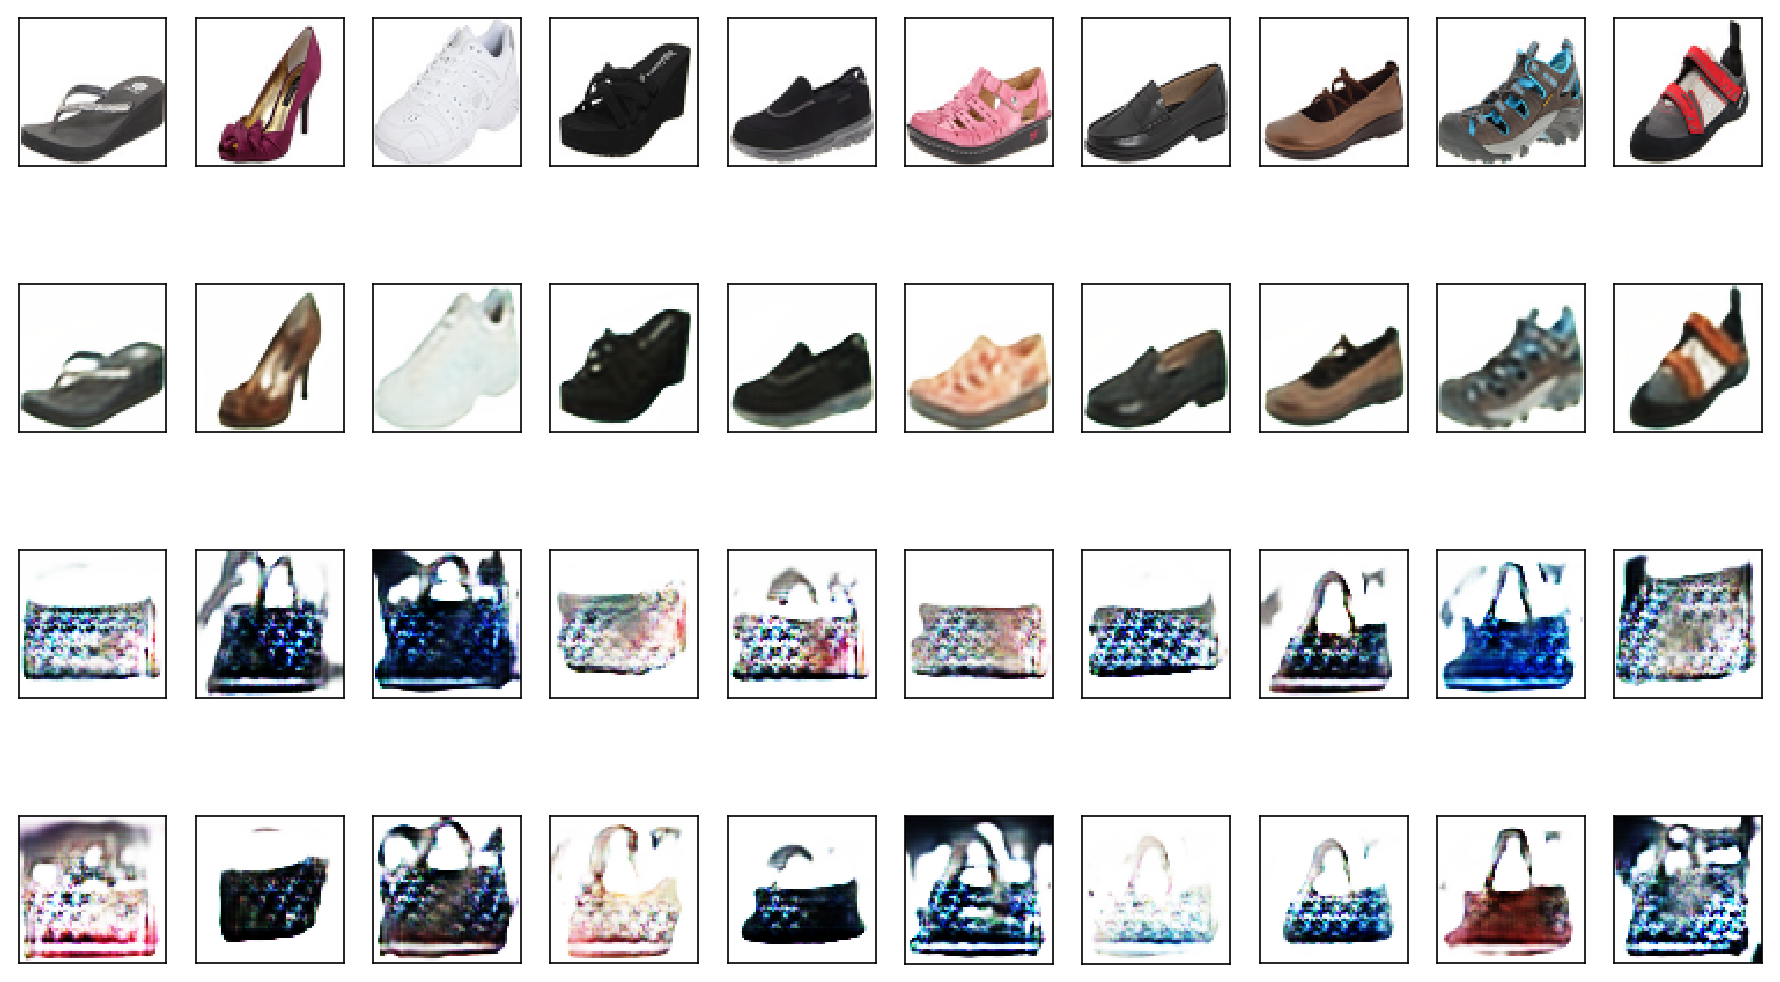

Computing FID
FID = 145.72824986953435
Elapsed time in update: 0.250794
Elapsed time in update: 0.175000
Elapsed time in update: 0.169326
Elapsed time in update: 0.169128
Elapsed time in update: 0.167214
Elapsed time in update: 0.168535
Elapsed time in update: 0.171939
Elapsed time in update: 0.173706
Elapsed time in update: 0.176456
Elapsed time in update: 0.167471
Iteration: 00010011/01000000
Elapsed time in update: 0.169561
Elapsed time in update: 0.165961
Elapsed time in update: 0.166399
Elapsed time in update: 0.165813
Elapsed time in update: 0.224793
Elapsed time in update: 0.173667
Elapsed time in update: 0.170832
Elapsed time in update: 0.178484
Elapsed time in update: 0.174935
Elapsed time in update: 0.172657
Iteration: 00010021/01000000
Elapsed time in update: 0.172073
Elapsed time in update: 0.210739
Elapsed time in update: 0.185158
Elapsed time in update: 0.173768
Elapsed time in update: 0.180785
Elapsed time in update: 0.169282
Elapsed time in update: 0.170396
Elapsed time

In [ ]:
print("Start training!")

# Start training
iterations = 0
while True:
    for it, (images_a_all, images_b_all) in enumerate(zip(train_loader_a, train_loader_b)):
        images_a, _ = images_a_all
        images_b, _ = images_b_all
        trainer.update_learning_rate()
        images_a, images_b = images_a.to(device).detach(), images_b.to(device).detach()

        with Timer("Elapsed time in update: %f"):
            # Main training code
            trainer.dis_update(images_a, images_b, config)
            trainer.gen_update(images_a, images_b, config)
            torch.cuda.synchronize()

        # Dump training stats in log file
        if iterations % config['log_iter'] == 0:
            print("Iteration: %08d/%08d" % (iterations + 1, max_iter))
            write_loss(iterations, trainer, writer)

        # Write images
        if iterations % config['image_save_iter'] == 0:
            clear_output(wait=True)
        
            print(f'Plotting, step = {iterations + 1}')
            
            with torch.no_grad():
                test_x_a, test_x_a_recon, test_x_ab1, test_x_ab2, \
                 test_x_b, test_x_b_recon, test_x_ba1, test_x_ba2 = trainer.sample(X_test_fixed, Y_test_fixed)
                train_x_a, train_x_a_recon, train_x_ab1, train_x_ab2, \
                    train_x_b, train_x_b_recon, train_x_ba1, train_x_ba2 = trainer.sample(X_fixed, Y_fixed)

            test_tensors = [test_x_a, test_x_a_recon, test_x_ab1, test_x_ab2,
                            test_x_b, test_x_b_recon, test_x_ba1, test_x_ba2]

            train_tensors = [train_x_a, train_x_a_recon, train_x_ab1, train_x_ab2,
                             train_x_b, train_x_b_recon, train_x_ba1, train_x_ba2]

            for j in range(len(test_tensors)):
                test_tensors[j] = tensor2img(test_tensors[j])
                train_tensors[j] = tensor2img(train_tensors[j])

            mode_tensor = [train_tensors, test_tensors]
            mode_gen = ["gen_a2b", "gen_b2a"]

            modes = ["train", "test"]
            for t in range(2):
                for k in range(2):
                    fig, axes = plt.subplots(4, 10, figsize=(15, 9), dpi=150)

                    for i in range(4):
                        for j in range(10):
                            if t > 0:
                                cur_img = mode_tensor[k][i + 4][j]
                            else:
                                cur_img = mode_tensor[k][i][j]

                            axes[i][j].imshow(cur_img)
                            axes[i][j].get_xaxis().set_visible(False)
                            axes[i][j].get_yaxis().set_visible(False)
                            
                    print(f'Step {iterations + 1}, {mode_gen[t]}, {modes[k]}')

                    plt.show(fig)
                    writer.add_figure(f'Step {iterations + 1}, {mode_gen[t]}, {modes[k]}',
                                      fig,
                                      global_step=iterations + 1)
                    
                    plt.close(fig)

        # Save network weights
        if iterations % config['snapshot_save_iter'] == 0:
            trainer.save(path_to_save_models, iterations)

            print('Computing FID')
            mu, sigma = get_Z_pushed_loader_stats(trainer, X_test_sampler.loader, device)
            fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
            print(f"FID = {fid}")
            writer.add_scalar('training fid',
                              fid,
                              iterations + 1)
            del mu, sigma

        iterations += 1
        if iterations >= max_iter:
            sys.exit('Finish training')